In [1]:
import numpy as np
import pandas as pd
import json as json
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
from o_plot import opl # a small local package dedicated to this project

In [3]:
# Prepare the data

In [4]:
# loading the data
file_name = 'Up_to_Belem_TE4AL2_data_new.json'
f = open(file_name)
All_data = json.load(f)
print(len(All_data))

148


## Note for the interpretation of the curves and definition of the statistical variables

The quantum state classifier (QSC) error rates $\widehat{r}_i$ in function of the number of experimental shots $n$ were determined for each highly entangled quantum state $\omega_i$ in the $\Omega$ set, with $i=1...m$.

The curves seen on the figures represents the mean of the QSC error rate $\widehat{r}_{mean}$ over the $m$ quantum states at each $n$ value.

This Monte Carlo simulation allowed to determine a safe shot number $n_s$ such that $\forall i\; \widehat{r}_i\le \epsilon_s$. The value of $\epsilon_s$ was set at 0.001.

$\widehat{r}_{max}$ is the maximal value observed among all the $\widehat{r}_i$ values for the determined  number of shots $n_s$.

Similarly, from the error curves stored in the data file, was computed the safe shot number $n_t$ such that $\widehat{r}_{mean}\le \epsilon_t$. The value of $\epsilon_t$ was set at 0.0005 after verifying that all $\widehat{r}_{mean}$ at $n_s$ were $\le \epsilon_s$ in the different experimental settings. 

Correspondance between variables names in the text and in the data base:

- $\widehat{r}_{mean}$: error_curve
- $n_s$: shots
- max ($\widehat{r}_i$) at $n_s$: shot_rate
- $\widehat{r}_{mean}$ at $n_s$: mns_rate
- $n_t$: m_shots
- $\widehat{r}_{mean}$ at $n_t$: m_shot_rate




In [5]:
# Calculate shot number 'm_shots' for mean error rate 'm_shot_rates' <= epsilon_t
len_data = len(All_data)
epsilon_t = 0.0005
window = 11
for i in range(len_data):            
    curve = np.array(All_data[i]['error_curve'])
    # filter the curve only for real devices:
    if All_data[i]['device']!="ideal_device":    
        curve = savgol_filter(curve,window,2) 
    # find the safe shot number:    
    len_c = len(curve)                               
    n_a = np.argmin(np.flip(curve)<=epsilon_t)+1                          
    if n_a == 1:
        n_a = np.nan
        m_r = np.nan
    else:
        m_r = curve[len_c-n_a+1]
    All_data[i]['min_r_shots'] = len_c-n_a
    All_data[i]['min_r'] = m_r

In [6]:
# find mean error rate at n_s
for i in range(len_data):
    i_shot = All_data[i]["shots"]
    if not np.isnan(i_shot):
        j = int(i_shot)-1        
        All_data[i]['mns_rate'] = All_data[i]['error_curve'][j]
    else:
        All_data[i]['mns_rate'] = np.nan

In [7]:
#defining the pandas data frame for statistics excluding from here ibmqx2 data
df_All= pd.DataFrame(All_data,columns=['shot_rates','shots', 'device', 'fidelity',
                                        'mitigation','model','id_gates',
                                        'QV', 'metric','error_curve',
                                        'mns_rate','min_r_shots','min_r']).query("device != 'ibmqx2'")

# any shot number >= 488 indicates that the curve calculation 
# was ended after reaching n = 500, hence this data correction:
df_All.loc[df_All.shots>=488,"shots"]=np.nan

# add the variable neperian log of safe shot number: 
df_All['log_shots'] = np.log(df_All['shots'])
df_All['log_min_r_shots'] = np.log(df_All['min_r_shots'])

### Error rates in function of chosen $\epsilon_s$ and $\epsilon_t$

In [8]:
print("max mean error rate at n_s over all experiments =", round(max(df_All.mns_rate[:-2]),6))

max mean error rate at n_s over all experiments = 0.000515


In [9]:
print("min mean error rate at n_t over all experiments =", round(min(df_All.min_r[:-2]),6))

min mean error rate at n_t over all experiments = 0.000225


In [10]:
print("max mean error rate at n_t over all experiments =", round(max(df_All.min_r[:-2]),6))

max mean error rate at n_t over all experiments = 0.0005


<AxesSubplot:ylabel='Frequency'>

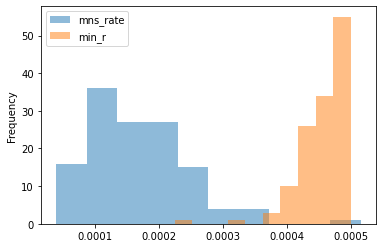

In [11]:
df_All.mns_rate[:-2].plot.hist(alpha=0.5, legend = True)
df_All.min_r[:-2].plot.hist(alpha=0.5, legend = True)

# Statistical overview

For this section, an ordinary linear least square estimation is performed.
The dependent variables tested are $ln\;n_s$ (log_shots) and $ln\;n_t$ (log_min_r_shots)

In [12]:
stat_model = ols("log_shots ~  metric",
                 df_All.query("device != 'ideal_device'")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                 9.932e-05
Date:                Sun, 28 Feb 2021   Prob (F-statistic):              0.992
Time:                        23:15:39   Log-Likelihood:                -97.198
No. Observations:                 128   AIC:                             198.4
Df Residuals:                     126   BIC:                             204.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.89

In [13]:
stat_model = ols("log_min_r_shots ~  metric",
                 df_All.query("device != 'ideal_device'")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                 0.0002891
Date:                Sun, 28 Feb 2021   Prob (F-statistic):              0.986
Time:                        23:15:39   Log-Likelihood:                -98.159
No. Observations:                 128   AIC:                             200.3
Df Residuals:                     126   BIC:                             206.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.66

In [29]:
stat_model = ols("log_shots ~  model+mitigation+id_gates+fidelity+QV",
                 df_All.query("device != 'ideal_device' & metric == 'sqeuclidean'")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     9.988
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           6.27e-07
Time:                        23:23:18   Log-Likelihood:                -28.701
No. Observations:                  64   AIC:                             69.40
Df Residuals:                      58   BIC:                             82.35
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.8533      2

In [15]:
stat_model = ols("log_min_r_shots ~  model+mitigation+id_gates+fidelity+QV",
                 df_All.query("device != 'ideal_device'& metric == 'sqeuclidean'")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     13.16
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           1.43e-08
Time:                        23:15:39   Log-Likelihood:                -24.867
No. Observations:                  64   AIC:                             61.73
Df Residuals:                      58   BIC:                             74.69
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.5234      1

#### Comments:

For the QSC, two different metrics were compared and at the end they gave the same output. For further analysis, the results obtained using the squared euclidean distance between distribution will be illustrated in this notebook, as it is more classical and strictly equivalent to the other classical Hellinger and Bhattacharyya distances. The Jensen-Shannon metric has however the theoretical advantage of being bayesian in nature and is therefore presented as an option for the result analysis.

Curves obtained for counts corrected by measurement error mitigation (MEM) are used in this presentation. MEM significantly reduces $n_s$ and  $n_t$. However, using counts distribution before MEM is presented as an option because they anticipate how the method could perform in devices with more qubits where obtaining the mitigation filter is a problem. 

Introducing a delay time $\delta t$ of 256 identity gates between state creation and measurement significantly increased $ln\;n_s$ and $ln\;n_t$ . 


# Detailed statistical analysis



### Determine the options
Running sequentially these cells will end up with the main streaming options

In [16]:
# this for Jensen-Shannon metric 
s_metric = 'jensenshannon'
sm = np.array([96+16+16+16]) # added Quito and Lima and Belem
SAD=0
# ! will be unselected by running the next cell

In [17]:
# mainstream option for metric: squared euclidean distance
# skip this cell if you don't want this option
s_metric = 'sqeuclidean'
sm = np.array([97+16+16+16]) # added Quito and Lima and Belem
SAD=2   

In [18]:
# this for no mitigation
mit = 'no'
MIT=-4
# ! will be unselected by running the next cell

In [19]:
# mainstream option: this for measurement mitigation
# skip this cell if you don't want this option
mit = 'yes'
MIT=0

## 1. Compare distribution models


In [20]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-20-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


### A look at $n_s$ and  $n_t$

In [21]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['shots','min_r_shots']].describe(percentiles=[0.5])

mitigation: yes   metric: sqeuclidean


shots                                       min_r_shots         \
              count    mean        std   min   50%    max       count   mean   
device                                                                         
ibmq_athens     4.0   40.75  10.078856  32.0  39.0   53.0         4.0  33.00   
ibmq_belem      4.0   39.00  15.077577  25.0  36.5   58.0         4.0  32.75   
ibmq_lima       4.0   50.50  25.722882  29.0  45.5   82.0         4.0  40.25   
ibmq_ourense    4.0   34.75   4.112988  30.0  34.5   40.0         4.0  27.25   
ibmq_quito      4.0  100.50  72.399355  39.0  79.0  205.0         4.0  76.75   
ibmq_santiago   4.0   38.75   8.180261  27.0  41.0   46.0         4.0  27.75   
ibmq_valencia   4.0   32.75   5.737305  25.0  34.0   38.0         4.0  25.75   
ibmq_vigo       4.0   32.50   7.724420  25.0  32.0   41.0         4.0  26.25   

                                             
                     std   min   50%    max  
device                                       
ibmq_athens    11.575837  23.0  31.0   47.0  
ibmq_belem     13.200379  21.0  30.0   50.0  
ibmq_lima      22.035955  22.0  35.0   69.0  
ibmq_ourense    4.991660  23.0  26.0   34.0  
ibmq_quito     55.162638  31.0  59.5  157.0  
ibmq_santiago   5.123475  22.0  28.0   33.0  
ibmq_valencia   4.787136  19.0  27.0   30.0  
ibmq_vigo       7.544314  19.0  25.5   35.0

### Ideal vs empirical model: no state creation - measurements delay

<Figure size 432x288 with 0 Axes>

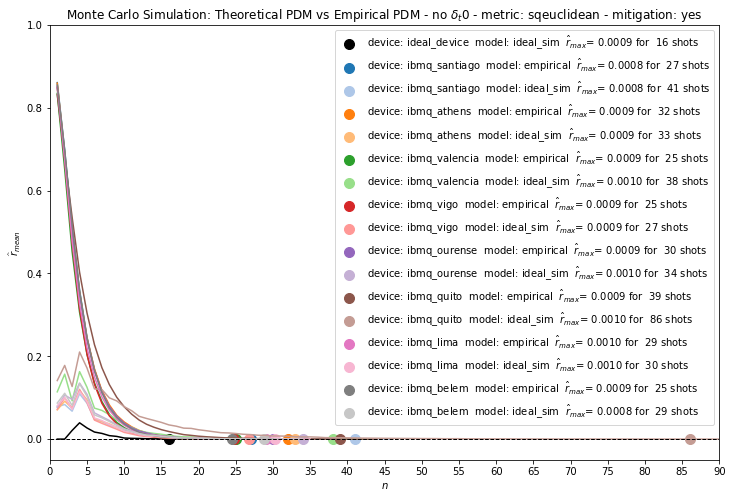

In [22]:
ADD=0+SAD+MIT
#opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,44,45])),    
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,52,53,60,61,68,69])),                                                      
            "Monte Carlo Simulation: Theoretical PDM vs Empirical PDM - no $\delta_t0$",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 90)

#### Paired t-test and Wilcoxon test

In [23]:
for depvar in ['log_shots', 'log_min_r_shots']:
#for depvar in ['shots', 'min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 0.0")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.356282  0.155304  3.218876  3.331566  3.663562
ideal_sim    8.0  3.611588  0.367515  3.295837  3.511434  4.454347 

paired data
[3.29583687 3.4657359  3.21887582 3.21887582 3.40119738 3.66356165
 3.36729583 3.21887582]
[3.71357207 3.49650756 3.63758616 3.29583687 3.52636052 4.4543473
 3.40119738 3.36729583] 

Ttest_relResult(statistic=-2.703455085610571, pvalue=0.03048624608052708)
WilcoxonResult(statistic=0.0, pvalue=0.0078125) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.107878  0.155857  2.944439  3.091042  3.433987
ideal_sim    8.0  3.294950  0.332811  3.044522  3.178054  4.094345 

paired data
[3.0910

### Ideal vs empirical model: with state creation - measurements delay of 256  id gates

<Figure size 432x288 with 0 Axes>

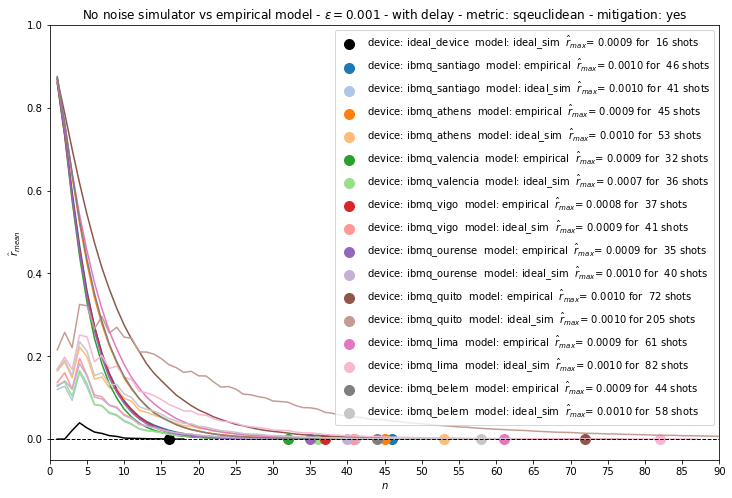

In [24]:
ADD=72+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,52,53,60,61,68,69])),                                                      
            "No noise simulator vs empirical model - $\epsilon=0.001$ - with delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 90)

#### Paired t-test and Wilcoxon test

In [25]:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0 ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2   with the ideal model, hence their exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest') 
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.804879  0.275711  3.465736  3.795426  4.276666
ideal_sim    8.0  4.057501  0.576714  3.583519  3.841932  5.323010 

paired data
[3.8286414  3.80666249 3.4657359  3.61091791 3.55534806 4.27666612
 4.11087386 3.78418963]
[3.71357207 3.97029191 3.58351894 3.71357207 3.68887945 5.32300998
 4.40671925 4.06044301] 

Ttest_relResult(statistic=-2.0745435276798316, pvalue=0.07670054021001)
WilcoxonResult(statistic=2.0, pvalue=0.0234375) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.576911  0.271657  3.258097  3.540013  4.077537
ideal_sim    8.0  3.871177  0.556633  3.401197  3.702748  5.056246 

paired data
[3.49650

### Pooling results obtained in circuit sets with and without creation-measurement delay

#### Paired t-test and Wilcoxon test

In [26]:
#for depvar in ['log_shots', 'log_min_r_shots']:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical'")
    df_ide=df_mod.query("model == 'ideal_sim'")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas:
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical   16.0  3.580581  0.316850  3.218876  3.510542  4.276666
ideal_sim   16.0  3.834544  0.520834  3.295837  3.701226  5.323010 

paired data
[3.29583687 3.4657359  3.21887582 3.21887582 3.40119738 3.66356165
 3.36729583 3.21887582 3.8286414  3.80666249 3.4657359  3.61091791
 3.55534806 4.27666612 4.11087386 3.78418963]
[3.71357207 3.49650756 3.63758616 3.29583687 3.52636052 4.4543473
 3.40119738 3.36729583 3.71357207 3.97029191 3.58351894 3.71357207
 3.68887945 5.32300998 4.40671925 4.06044301] 

Ttest_relResult(statistic=-3.411743256395652, pvalue=0.0038635533717249343)
WilcoxonResult(statistic=5.0, pvalue=0.00030517578125) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                              

#### Statsmodel Ordinary Least Square (OLS)  Analysis

In [27]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  model + id_gates + device + model*id_gates" ,
                 df_mod).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     8.475
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           2.24e-05
Time:                        23:15:43   Log-Likelihood:                 7.0025
No. Observations:                  32   AIC:                             7.995
Df Residuals:                      21   BIC:                             24.12
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [28]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_min_r_shots ~  model + id_gates + device + model*id_gates",
                 df_mod).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     11.55
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           1.87e-06
Time:                        23:15:43   Log-Likelihood:                 10.538
No. Observations:                  32   AIC:                            0.9231
Df Residuals:                      21   BIC:                             17.05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

##### Comments:
The classical paired t-test and Wilcoxon test favour an advantage of the empirical model. 

The OLS model confirms the empirical model advantage on the ideal device model for what concerns $ln\;n_s$ but not $ln\;n_t$.